# Testing RetinaNet Edge Inference
## Import Libraries

In [1]:
# show images inline
%matplotlib inline

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import keras
import boto3
import sagemaker
import h5py
import json
import tensorflow as tf

# enter model prefix
model_prefix = 'haas-sagemaker' # cfn model prefix
backbone = 'resnet50' # default backbone

Using TensorFlow backend.


## Create Local Scoring Service

In [2]:
# SageMaker ffully traine dmodel
model_path = '/home/ec2-user/SageMaker/'

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

def get_model(model_path):
    model = models.load_model(os.path.join(model_path, 'model.h5'), backbone_name=backbone)
    model = models.convert_model(model)
    return model

def predict(data, path):
    clf = get_model(path)
    return clf.predict_on_batch(data)

## Load Image

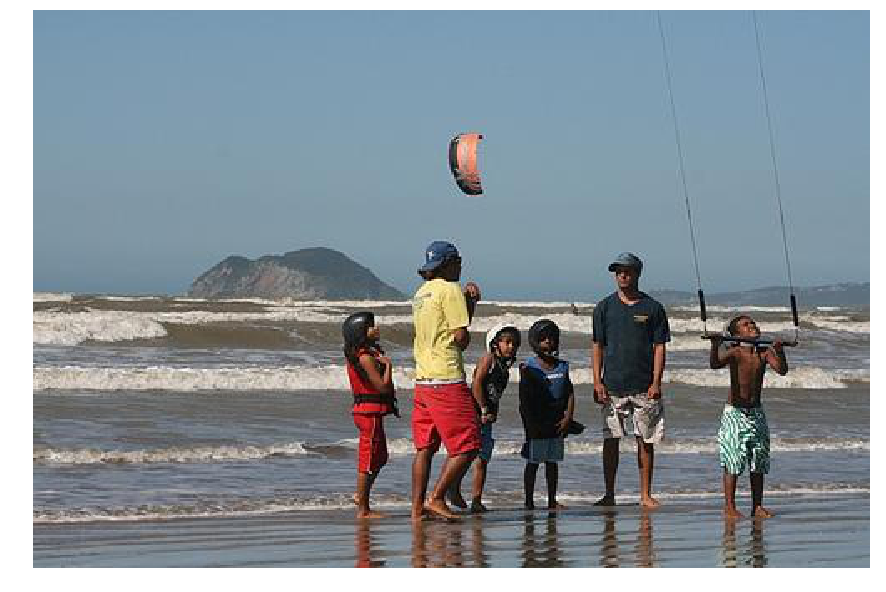

In [3]:
# load image
image = read_image_bgr('/home/ec2-user/SageMaker/tmp/images/10.jpg')

# Labels
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

# sample image
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

## Create Payload

In [4]:
# preprocess image for inference
image = preprocess_image(image)
image, scale = resize_image(image)

## Invoke Scoring Service

In [6]:
# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

# Run inference
boxes, scores, labels = predict(np.expand_dims(image, axis=0), model_path)
boxes /= scale

## View Prediction Results

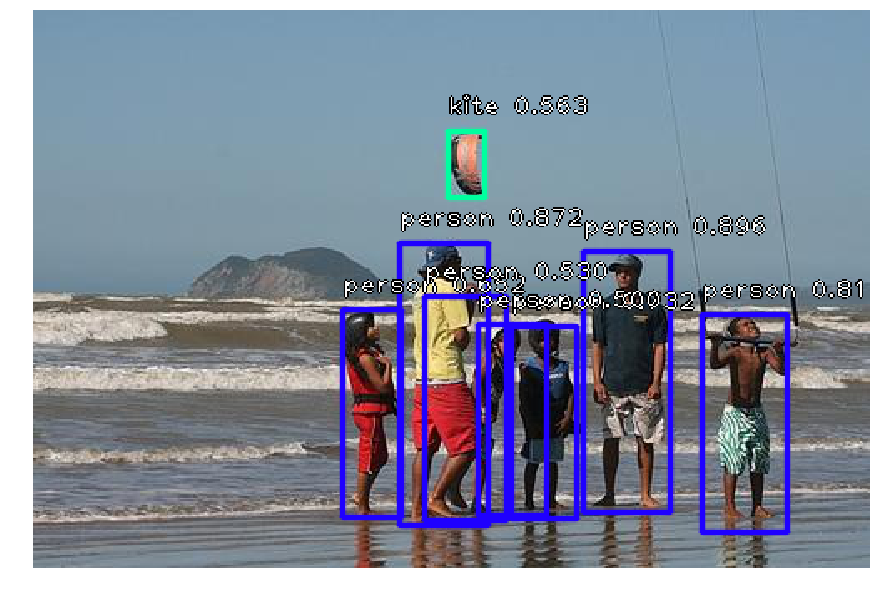

In [7]:
# visualize detections
for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can break
    if score < 0.5:
        break
        
    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    draw_caption(draw, b, caption)

# final image
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()